## ANALYSIS

In [216]:
# RESULT_JSON = "/Users/law/repos/viper/results/all_ops/all_ops_2020-06-10-18-53.json"
# RESULT_JSON = "/Users/law/repos/viper/results/all_ops/all_ops_2020-06-15-12-10.json"
DRAM_JSON = "/Users/law/repos/viper/results/all_ops/all_ops_2020-06-21-00-56.json"
VIPER_JSON = "/Users/law/repos/viper/results/all_ops/all_ops_2020-06-21-12-08.json"

RESULT_JSON = "/Users/law/repos/viper/results/all_ops/full_all_ops.json"

In [217]:
import json

results_raw = json.loads(open(RESULT_JSON).read())
# assert results_raw["context"]["library_build_type"] != "debug"
BENCHMARKS =  results_raw["benchmarks"]
# print(BENCHMARKS)

In [237]:
from collections import defaultdict
runs = defaultdict(list)

ROCKS_DISK = ('DiskRocksDb', "RocksDB-SSD")
ROCKS = ('PmemRocksDb', "RocksDB")
PMEMKV = ('PmemKV', "PmemKV")
VIPER = ('Viper', 'Viper')
DRAM_MAP = ('DramMap', 'TBB Map')
FASTER = ('Faster', "FASTER")

ALL_FIXTURES = [VIPER, DRAM_MAP, ROCKS ] #PMEMKV, ROCKS_NVM,]
ALL_BM_TYPES = ['insert', 'get', 'update', 'delete']

def get_bm_type(bm_type_str):
    for t in ALL_BM_TYPES:
        if t in bm_type_str:
            return t
    raise RuntimeError(f"Unknown bm_type: {bm_type_str}")

for bm in BENCHMARKS:
    found = False
    for (fixture, _) in ALL_FIXTURES:
        bm_type = get_bm_type(bm['name'])
        if fixture in bm['name']:
            runs[(fixture, bm_type)].append(bm)
            found = True
            break
    if not found: raise RuntimeError(f"Unknown fixture {bm['name']}")

for fixture, _ in ALL_FIXTURES:
    for bm_type in ALL_BM_TYPES:
        runs[(fixture, bm_type)].sort(key=lambda x: x['threads'])

pprint.pprint(runs)

defaultdict(<class 'list'>,
            {('DramMap', 'delete'): [{'cpu_time': 16424859.022,
                                      'found': 50000000.0,
                                      'items_per_second': 3036519.6538022314,
                                      'iterations': 1,
                                      'name': 'DramMapFixture<KeyType16,ValueType200>/delete/100000000/50000000/iterations:1/repeats:1/real_time/threads:1',
                                      'real_time': 16466220.114001771,
                                      'repetition_index': 0,
                                      'repetitions': 1,
                                      'run_name': 'DramMapFixture<KeyType16,ValueType200>/delete/100000000/50000000/iterations:1/repeats:1/real_time/threads:1',
                                      'run_type': 'iteration',
                                      'threads': 1,
                                      'time_unit': 'us'},
                                     

                                          'repetitions': 1,
                                          'run_name': 'PmemRocksDbFixture<KeyType16,ValueType200>/update/100000000/50000000/iterations:1/repeats:1/real_time/threads:2',
                                          'run_type': 'iteration',
                                          'threads': 2,
                                          'time_unit': 'us'},
                                         {'cpu_time': 612989627.80225,
                                          'found': 50000000.0,
                                          'items_per_second': 46603.64734755386,
                                          'iterations': 4,
                                          'name': 'PmemRocksDbFixture<KeyType16,ValueType200>/update/100000000/50000000/iterations:1/repeats:1/real_time/threads:4',
                                          'real_time': 268219350.01737803,
                                          'repetition_index': 0,
       

## PLOTS

In [238]:
from matplotlib import rcParams
import numpy as np
import matplotlib.pyplot as plt
rcParams.update(json.loads(open("matplot_conf.json").read()))

import pprint
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

MILLION = 1_000_000



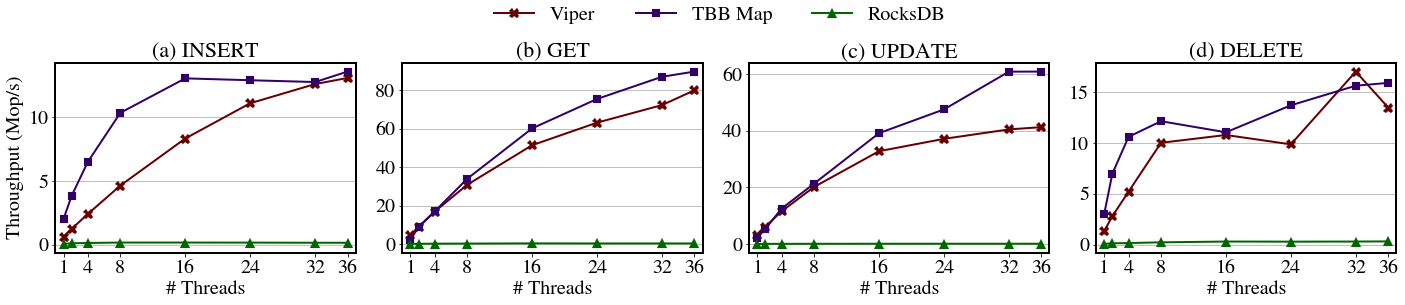

In [239]:
fig, (insert_ax, get_ax, update_ax, delete_ax) = plt.subplots(1, 4, figsize=(20, 4))

#           red        blue       green  
COLORS = ['#660000', '#330066', '#006600', ]
MARKERS = [('X', 10), ("s", 8), ("^", 10), ("o", 8), ("|", 8),]

def get_bm_ax(bm_type):
    if bm_type == 'insert': return insert_ax
    if bm_type == 'get': return get_ax
    if bm_type == 'update': return update_ax
    if bm_type == 'delete': return delete_ax
    raise RuntimeError(f"Unknown bm_type {bm_type}")

num_threads = sorted({run['threads'] for run in list(runs.values())[0]})

for bm_type, letter in zip(ALL_BM_TYPES, ['a', 'b', 'c', 'd']):
    ax = get_bm_ax(bm_type)
    ax.set_xlabel("# Threads", fontsize=20)
    ax.set_title(f"({letter}) {bm_type.upper()}", fontsize=22)
    colors = iter(COLORS)
    markers = iter(MARKERS)
    for (fixture, _) in ALL_FIXTURES:
        r = [run['items_per_second'] / MILLION for run in runs[(fixture, bm_type)]]
        marker, ms = next(markers)
        ax.plot(num_threads, r, marker=marker, ms=ms, color=next(colors), markeredgewidth=0.1, lw=2)
    x_ticks = np.append(ax.get_xticks(), 36)
    ax.set_xticks([1, 4, 8, 16, 24, 32, 36])
    ax.set_xlim(0, 37)
    ax.grid(axis='y', which='major')
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)

# ax.plot(num_threads, rocks_disk_runs, label="DIMM", ls='-', color='grey')
# ax.plot(num_threads, rocks_nvm_runs, label="Block", ls='--', color='#BA2121')


insert_ax.set_ylabel("Throughput (Mop/s)", fontsize=20)
# fig.legend(frameon=True, loc="upper center", borderaxespad=0.1,) #, bbox_to_anchor=(0.55, 0.54))
fig.legend(loc='upper center', labels=[f[1] for f in ALL_FIXTURES], 
           bbox_to_anchor=(0.5, 1.1), ncol=6, frameon=False,
           fontsize=20)

# ax.grid(axis='y', which='major')
# fig.savefig('charts/all_ops.pdf', bbox_inches='tight')